# Simulated single cell expression data with dropout

This example uses TACCO to annotate simulated single cell data, simulated using a modified variant (Moriel) of scsim (Kotliar).

(Moriel): Moriel, N. Extension of scsim single-cell RNA-sequencing data simulations. github.com/nitzanlab/scsim-ext (2023)

(Kotliar): Kotliar, D. scsim: simulate single-cell RNA-SEQ data using the Splatter statistical framework but implemented in python. github.com/dylkot/scsim (2021)

In [1]:
import os
import sys
import matplotlib

import pandas as pd
import numpy as np
import scipy.sparse
import scanpy as sc

import tacco as tc
from scsim import scsim

# The notebook expects to be executed either in the workflow directory or in the repository root folder...
sys.path.insert(1, os.path.abspath('workflow' if os.path.exists('workflow/common_code.py') else '..')) 
import common_code

In [2]:
env_path = common_code.find_path('results/env_links')

## Simulate single cell data

Simulate data with various dropout levels with a known ground truth

In [3]:
ngenes = 25000
descale = 1.0
ndoublets = 100
K = 13
nproggenes = 1000
proggroups = [1,2,3,4]
progcellfrac = .35
ncells = 1500
deprob = .025

seed = 111

deloc = 2.0

# simulating true counts (in simulator.counts)
simulator = scsim(ngenes=ngenes, ncells=ncells, ngroups=K, libloc=7.64, libscale=0.78,
             mean_rate=7.68,mean_shape=0.34, expoutprob=0.00286,
             expoutloc=6.15, expoutscale=0.49,
             diffexpprob=deprob, diffexpdownprob=0., diffexploc=deloc, diffexpscale=descale,
             bcv_dispersion=0.448, bcv_dof=22.087, ndoublets=ndoublets,
             nproggenes=nproggenes, progdownprob=0., progdeloc=deloc,
             progdescale=descale, progcellfrac=progcellfrac, proggoups=proggroups,
             minprogusage=.1, maxprogusage=.7, seed=seed)
simulator.simulate()

Simulating cells
Simulating gene params
Simulating program
Simulating DE
Simulating cell-gene means
   - Getting mean for activity program carrying cells
   - Getting mean for non activity program carrying cells
   - Normalizing by cell libsize
Simulating doublets
Adjusting means
Simulating counts with scsim


In [4]:
reference = sc.AnnData(scipy.sparse.csr_matrix(simulator.counts), obs=simulator.cellparams, var=simulator.geneparams)
reference.obs['group'] = reference.obs['group'].astype('category')
# fitting number of zeros vs log mean curve
dropshape, dropmidpoint = simulator.fit_dropout()
dropout_midpoints = [1.0,-1.0,-3.0,-5.0,-7.0]

# to add technical dropout noise, we can decrease the sigmoid's dropmidpoint to increase the dropout (in simulator.countswdrop)
sdatas = {}
for dropout_midpoint in dropout_midpoints:
    simulator.dropshape = dropshape
    simulator.dropmidpoint = dropout_midpoint
    simulator.simulate_dropouts()

    sdata = sc.AnnData(scipy.sparse.csr_matrix(simulator.countswdrop), obs=simulator.cellparams, var=simulator.geneparams)
    sdata.obs['group'] = sdata.obs['group'].astype('category')
    
    sdatas[dropout_midpoint] = sdata

## Plotting options

In [5]:
highres = False
default_dpi = 100.0
if highres:
    matplotlib.rcParams['figure.dpi'] = 648.0
    hr_ext = '_hd'
else:
    matplotlib.rcParams['figure.dpi'] = default_dpi
    hr_ext = ''

axsize = np.array([3,3])*1.0

## Visualize simulated data without dropout

Create UMAP for the simulated data without dropout

SCumap...SCprep...time 1.4392147064208984
time 26.896665811538696


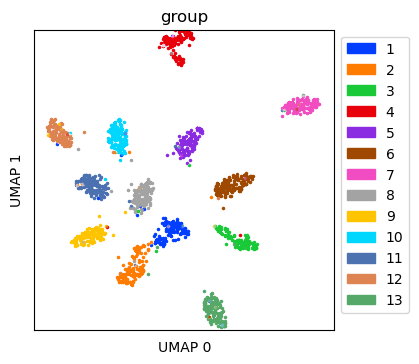

In [6]:
ref_umap = tc.utils.umap_single_cell_data(reference)
fig = tc.pl.scatter(ref_umap, keys='group', position_key='X_umap', joint=True, point_size=5, axsize=axsize, noticks=True,
axes_labels=['UMAP 0','UMAP 1']);

## Visualize simulated data with dropout

Create UMAP for the simulated data with dropout

SCumap...SCprep...time 0.5789980888366699
time 8.304261207580566


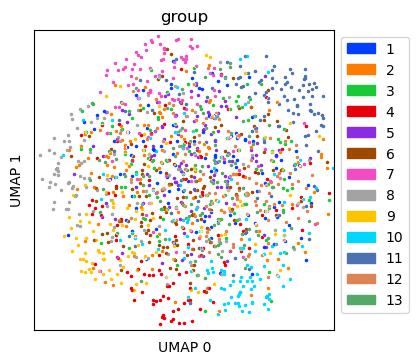

In [7]:
tdata = sdatas[-1.0]
tdata_umap = tc.utils.umap_single_cell_data(tdata)
fig = tc.pl.scatter(tdata_umap, keys='group', position_key='X_umap', joint=True, point_size=5, axsize=axsize, noticks=True,
axes_labels=['UMAP 0','UMAP 1']);

## Annotate the data with dropout with cell types

Annotation is done on cell type level with multi_center=10 to capture variation within a cell type.

In [8]:
tc.tl.annotate(tdata, reference, 'group', result_key='TACCO', multi_center=10, assume_valid_counts=True)

Starting preprocessing
Annotation profiles were not found in `reference.varm["group"]`. Constructing reference profiles with `tacco.preprocessing.construct_reference_profiles` and default arguments...
Finished preprocessing in 0.42 seconds.
Starting annotation of data with shape (1500, 19737) and a reference of shape (1500, 19737) using the following wrapped method:
+- platform normalization: platform_iterations=0, gene_keys=group, normalize_to=adata
   +- multi center: multi_center=10 multi_center_amplitudes=True
      +- bisection boost: bisections=4, bisection_divisor=3
         +- core: method=OT annotation_prior=None
mean,std( rescaling(gene) )  0.37671331182229645 0.19547104710406613
bisection run on 1
bisection run on 0.6666666666666667
bisection run on 0.4444444444444444
bisection run on 0.2962962962962963
bisection run on 0.19753086419753085
bisection run on 0.09876543209876543
Finished annotation in 7.44 seconds.


AnnData object with n_obs × n_vars = 1500 × 25000
    obs: 'group', 'libsize', 'has_program', 'program_usage', 'is_doublet', 'group2'
    var: 'BaseGeneMean', 'is_outlier', 'outlier_ratio', 'gene_mean', 'prog_gene', 'prog_genemean', 'group1_DEratio', 'group1_genemean', 'group2_DEratio', 'group2_genemean', 'group3_DEratio', 'group3_genemean', 'group4_DEratio', 'group4_genemean', 'group5_DEratio', 'group5_genemean', 'group6_DEratio', 'group6_genemean', 'group7_DEratio', 'group7_genemean', 'group8_DEratio', 'group8_genemean', 'group9_DEratio', 'group9_genemean', 'group10_DEratio', 'group10_genemean', 'group11_DEratio', 'group11_genemean', 'group12_DEratio', 'group12_genemean', 'group13_DEratio', 'group13_genemean'
    uns: 'TACCO_mc10'
    obsm: 'TACCO_mc10', 'TACCO'
    varm: 'TACCO_mc10'

## Benchmark annotation methods on the simulated dropout data

Define parameters for the annotation methods to use

In [9]:
methods = {
    'NMFreg':{'method': 'NMFreg',},
    'RCTD':{'method': 'RCTD', 'conda_env': f'{env_path}/RCTD_env',},
    'SVM':{'method':'svm',},
    'SingleR':{'method':'SingleR', 'conda_env': f'{env_path}/SingleR_env',},
    'WOT':{'method': 'WOT',},
    'TACCO': {'method': 'OT', 'multi_center': 10,},
}

In [10]:
results = {}
for dropout_midpoint in dropout_midpoints:
    for method,params in methods.items():
        print(f'running method {method} for dropout midpoint {dropout_midpoint} ...', end='')
        try:
            results[(dropout_midpoint,method)] = tc.benchmarking.benchmark_annotate(sdatas[dropout_midpoint],reference,annotation_key='group',**params, assume_valid_counts=True);
        except:
            pass # catch failing methods
        print(f'done')

running method NMFreg for dropout midpoint 1.0 ...done
running method RCTD for dropout midpoint 1.0 ...done
running method SVM for dropout midpoint 1.0 ...done
running method SingleR for dropout midpoint 1.0 ...done
running method WOT for dropout midpoint 1.0 ...done
running method TACCO for dropout midpoint 1.0 ...done
running method NMFreg for dropout midpoint -1.0 ...done
running method RCTD for dropout midpoint -1.0 ...done
running method SVM for dropout midpoint -1.0 ...done
running method SingleR for dropout midpoint -1.0 ...done
running method WOT for dropout midpoint -1.0 ...done
running method TACCO for dropout midpoint -1.0 ...done
running method NMFreg for dropout midpoint -3.0 ...done
running method RCTD for dropout midpoint -3.0 ...done
running method SVM for dropout midpoint -3.0 ...done
running method SingleR for dropout midpoint -3.0 ...done
running method WOT for dropout midpoint -3.0 ...done
running method TACCO for dropout midpoint -3.0 ...done
running method NMFreg 

In [11]:
for (dropout_midpoint,method),result in results.items():
    unused_key = tc.utils.find_unused_key(sdatas[dropout_midpoint].obsm)
    sdatas[dropout_midpoint].obsm[unused_key] = results[(dropout_midpoint,method)]['annotation']
    max_correct = tc.ev.compute_err(sdatas[dropout_midpoint], unused_key, 'group', err_method='max_correct')[unused_key]
    del sdatas[dropout_midpoint].obsm[unused_key]
    results[(dropout_midpoint,method)]['max_correct'] = max_correct

In [12]:
res_df = pd.DataFrame([
    [dropout_midpoint,method,v['max_correct'],v['max_mem_usage_GB'],v['benchmark_time_s']]
    for (dropout_midpoint,method),v in results.items()
],columns=['dropout_midpoint','method','max_correct','memory (GB)','time (s)'])
quantities = [c for c in res_df.columns if c not in ['dropout_midpoint','method'] ]
methods = res_df['method'].unique()

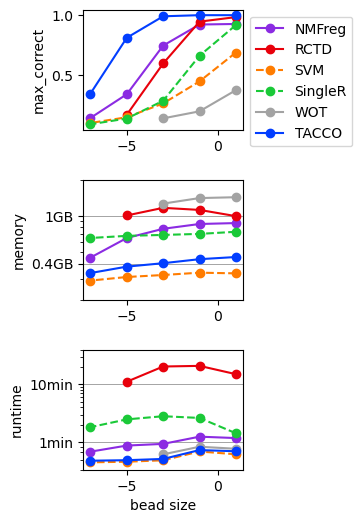

In [13]:
fig,axs = tc.pl.subplots(1,len(quantities), axsize=np.array([4,3])*0.4, x_padding=0.7, y_padding=0.5)
colors = {m:common_code.method_color(m) for m in methods}
styles = {m:common_code.method_style(m) for m in methods}
res_df = res_df.loc[~res_df[quantities].isna().all(axis=1)]
for iy_ax, qty in enumerate(quantities):
    ax = axs[iy_ax,0]

    x = res_df['dropout_midpoint']
    y = res_df[qty]

    if qty == 'time (s)': # part 1 of adding second, minute and hour marker: plot the lines under the data

        ynew = np.array([0.1,1,10,60,600,3600,36000])
        ynew_minor = np.concatenate([np.arange(0.1,1,0.1),np.arange(1,10,1),np.arange(10,60,10),np.arange(60,600,60),np.arange(600,3600,600),np.arange(3600,36000,3600)]).flatten()
        ynewlabels = np.array(['0.1s','1s','10s','1min','10min','1h','10h'])
        ymin = y.min() * 0.5
        ymax = y.max() * 2.0
        ynewlabels = ynewlabels[(ynew > ymin) & (ynew < ymax)]
        ynew = ynew[(ynew > ymin) & (ynew < ymax)]
        ynew_minor = ynew_minor[(ynew_minor > ymin) & (ynew_minor < ymax)]
        for yn in ynew:
            ax.axhline(yn, color='gray', linewidth=0.5)

    elif qty == 'memory (GB)':

        ynew = np.array([0.1,0.4,1,4,10,40,100])
        ynew_minor = np.concatenate([np.arange(0.1,1,0.1),np.arange(1,10,1),np.arange(10,100,10),np.arange(100,1000,100)]).flatten()
        ynewlabels = np.array(['0.1GB','0.4GB','1GB','4GB','10GB','40GB','100GB'])
        ymin = y.min() * 0.5
        ymax = y.max() * 2.0
        ynewlabels = ynewlabels[(ynew > ymin) & (ynew < ymax)]
        ynew = ynew[(ynew > ymin) & (ynew < ymax)]
        ynew_minor = ynew_minor[(ynew_minor > ymin) & (ynew_minor < ymax)]
        for yn in ynew:
            ax.axhline(yn, color='gray', linewidth=0.5)

    for m in methods:
        selector = res_df['method'] == m
        if selector.sum() == 0:
            continue
        ax.plot(x[selector],y[selector],label=m,marker='o',color=colors[m],ls=styles[m],)
    if iy_ax == axs.shape[0] - 1:
        ax.set_xlabel('bead size')
    if qty == 'time (s)':
        ax.set_ylabel('runtime')
    elif qty == 'memory (GB)':
        ax.set_ylabel('memory')
    else:
        ax.set_ylabel(f'{qty}')
    if qty in ['time (s)','memory (GB)']:
        ax.set_yscale('log')

    if qty in ['time (s)','memory (GB)']: # part 2 off adding second, minute and hour marker: add the second y axis after rescaling the first y axis to log scale
        ax.set_yticks(ynew_minor,minor=True)
        ax.set_yticks(ynew)
        ax.set_yticklabels(ynewlabels)
        ax.set_yticklabels([],minor=True)

    if iy_ax == 0:
        ax.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)